In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from functools import lru_cache

plt.style.use('ggplot')

In [2]:
class CountinuousLogisticRegression(LogisticRegression):

  @staticmethod
  def from_countinuous_to_weighted_binary_labels(labels, features):
    """Transforms a dataset with continuous labels into a bigger dataset with weighted
    binary labels. See explanation above.
    """
    weigths_positive = labels
    weigths_negative = 1 - labels
    label_positive = np.ones_like(labels)
    label_negative = np.zeros_like(labels)

    weights = np.hstack((weigths_positive, weigths_negative))
    weighted_labels = np.hstack((label_positive, label_negative))
    weighted_features = scipy.sparse.vstack((features, features))

    mask = (weights > 0)
    return weighted_labels[mask], weighted_features[mask], weights[mask]

  def fit(self, X, y):
    # 1. Generate dataset, use continuous labels to weighted dataset trick
    weighted_labels, weighted_features, weights = self.from_countinuous_to_weighted_binary_labels(y, X)

    # 2. Train model
    return LogisticRegression.fit(self, weighted_features, weighted_labels, sample_weight=weights)

In [3]:
np.random.seed(21)

GOOD = "good"
BAD = "bad"

def sample_conversions(is_good_mask, p_conversion):
  return np.random.binomial(1, p_conversion, len(is_good_mask)) * is_good_mask

def sample_bids(mean, sample_size, size):
  alpha = mean * sample_size
  beta = (1 - mean) * sample_size
  return np.random.beta(alpha, beta, size=size)


def generate_timeline(timeline_avg_size, p_good, p_conversion):
  display_opportunities = np.random.choice(
    [GOOD, BAD],
    size=np.random.geometric(1. / timeline_avg_size),
    replace=True,
    p=[p_good, 1 - p_good]
  )

  # competition_bids = np.random.uniform(size = len(display_opportunities))
  # What would be the good beta distribution ? based on which valuation ?
  competition_bids = np.where(
      display_opportunities == GOOD,
      sample_bids(mean=0.5, sample_size=10, size=len(display_opportunities)),
      sample_bids(mean=0.1, sample_size=10, size=len(display_opportunities))
  )

  is_good_mask = display_opportunities == GOOD
  conversions = sample_conversions(is_good_mask, p_conversion)

  return display_opportunities, competition_bids, conversions

def generate_timelines(first_uid, n_timelines, timeline_avg_size, p_good, p_conversion):
  return [
      (user_id, *generate_timeline(timeline_avg_size, p_good, p_conversion))
      for user_id in range(first_uid, first_uid + n_timelines)
  ]

In [4]:
class ConstantBidderModel:
  def __init__(self, bid):
    self.bid = bid

  def predict(self, state):
    return self.bid


class LastTouchModel:
  def fit(self, training_logs):
    self.encoder = OneHotEncoder(handle_unknown='ignore')

    features = self.encoder.fit_transform(training_logs[["display_state"]].values)
    labels = training_logs["last_display_conversion"]
    self.model = LogisticRegression(max_iter=1000, penalty='none')
    self.model.fit(features, labels)
    return self

  def predict(self, display_state):
    features = self.encoder.transform([[display_state]])
    return self.model.predict_proba(features)[:, 1]


class LastTouchModelWithMultiplier(LastTouchModel):
  def __init__(self, bid_multiplier):
    LastTouchModel.__init__(self)
    self.bid_multiplier = bid_multiplier

  def predict(self, display_state):
    return LastTouchModel.predict(self, display_state) *  self.bid_multiplier


def run_one_iteration(labels, features, history_ids, total_history_id_reward, model):
  """Return the new labels obtained after one iteration of the robust label attribution
  fixed point algorithm
  """
  # In our dataset, we know in advance that many displays will not get any
  # credit from the label attribution. Either:
  #   1. because they have not been clicked
  #   2. because no attributed sales were corresponding to this history_id.
  # These displays remain attached with a zero label while the remaining ones
  # will have a variable label computed with the fixed point iterations.
  to_update_mask = (total_history_id_reward > 0)

  labels_to_update, features_to_update = labels[to_update_mask], features[to_update_mask]

  # Step 2, compute valuations
  model.fit(features, labels)

  model_predictions = model.predict_proba(features_to_update)[:, 1]
  display_valuation = model_predictions

  predictions_per_display_to_update = pd.DataFrame({
    'feature_index': np.arange(display_valuation.shape[0]),
    'history_id': history_ids[to_update_mask],
    'display_valuation': display_valuation,
    'total_history_id_rewards': total_history_id_reward[to_update_mask],
  })

  # Step 3, compute new labels proportionally to the display valuations
  total_uid_valuation_dict = predictions_per_display_to_update.groupby('history_id').agg(total_history_id_valuation=('display_valuation', 'sum')).to_dict()["total_history_id_valuation"]
  predictions_per_display_to_update["total_history_id_valuation"] = predictions_per_display_to_update["history_id"].map(total_uid_valuation_dict)

  # Use fixed point characterization to update the labels
  updated_labels = (
    predictions_per_display_to_update['display_valuation'].values
    / predictions_per_display_to_update['total_history_id_valuation'].values
    * predictions_per_display_to_update['total_history_id_rewards'].values
  )

  next_labels = labels.copy()
  next_labels[to_update_mask] = updated_labels

  # Ensure we have just spread the labels
  np.testing.assert_almost_equal(sum(updated_labels), sum(labels))
  np.testing.assert_almost_equal(sum(next_labels), sum(labels))

  return next_labels

class RobustLabelAttributionModel:
  def __init__(self, n_iterations=10):
    self.n_iterations = n_iterations

  def _compute_label_attribution(self, training_logs):
    current_dataset = training_logs.copy()
    current_dataset["label"] = current_dataset["last_display_conversion"]
    total_uid_rewards_dict = current_dataset.groupby('uid').agg(total_uid_rewards=('label', 'sum')).to_dict()["total_uid_rewards"]
    current_dataset["total_uid_rewards"] = current_dataset["uid"].map(total_uid_rewards_dict)

    labels = training_logs["last_display_conversion"].values.astype(float)
    encoder = OneHotEncoder(handle_unknown='ignore')
    features = encoder.fit_transform(current_dataset[["display_state"]].values)
    model = CountinuousLogisticRegression(max_iter=1000, penalty="none", warm_start=True)

    for _ in range(self.n_iterations):
      labels = run_one_iteration(labels, features, current_dataset["uid"].values, current_dataset["total_uid_rewards"].values, model)

    return labels

  def fit(self, training_logs):
    self.encoder = OneHotEncoder(handle_unknown='ignore')
    features = self.encoder.fit_transform(training_logs[["display_state"]].values)
    labels = self._compute_label_attribution(training_logs)
    self.model = CountinuousLogisticRegression(max_iter=1000, penalty='none')
    self.model.fit(features, labels)
    return self

  def predict(self, display_state):
    features = self.encoder.transform([[display_state]])
    return self.model.predict_proba(features)[:, 1]

def marginal_return(n_conversions):
  return int(n_conversions > 0)

def bid_on_timeline(model, timeline):
  @lru_cache()
  def model_predict(display_state):
    return model.predict(display_state)

  user_id, display_opportunities, competition_bids, conversions = timeline

  won_displays = []
  won_conversions = []
  uid_collected_data = []
  for display_opportunity, competition_bid, conversion in zip(
      display_opportunities, competition_bids, conversions
    ):
    display_state = "_".join(won_displays + [display_opportunity])
    bid = model_predict(display_state)

    if bid > competition_bid:
      won_displays += [display_opportunity]
      won_conversions += [conversion]
      uid_collected_data += [{
        "uid": user_id,
        "display_state": display_state,
        "display_cost": competition_bid, # Second price auction
        "last_display_conversion": 0,
      }]

  # If there is a conversion assign it to the last display (as the advertiser would do)
  uid_conversions = marginal_return(sum(won_conversions))
  if uid_conversions > 0:
    uid_collected_data[-1]["last_display_conversion"] = uid_conversions

  return uid_collected_data


class RobustLabelAttributionModelWithMultiplier(RobustLabelAttributionModel):
  def __init__(self, n_iterations=10, bid_multiplier=1.0):
    RobustLabelAttributionModel.__init__(self, n_iterations=n_iterations)
    self.bid_multiplier = bid_multiplier

  def predict(self, display_state):
    return RobustLabelAttributionModel.predict(self, display_state) *  self.bid_multiplier

In [5]:
def evaluate_model(model, training_logs, timelines):
  if training_logs is not None:
    model.fit(training_logs)

  collected_data = []
  uid_rewards = []
  for timeline in timelines:
    uid_collected_data = bid_on_timeline(model, timeline)
    collected_data += uid_collected_data

  return pd.DataFrame(collected_data)

def compute_payoff(logs):
  total_cost = logs["display_cost"].sum()
  total_gain = logs["last_display_conversion"].sum()
  return total_gain - total_cost


In [7]:
timeline_avg_size, p_good, p_conversion = 4, 0.5, 0.5
n_timelines = 10_000

timelines = generate_timelines(0, n_timelines, timeline_avg_size, p_good, p_conversion)
constant_bidder_model = ConstantBidderModel(0.5)
training_logs = evaluate_model(constant_bidder_model, None, timelines)

In [8]:
%%time

last_touch_training_logs = training_logs.copy()
fipla_training_logs = training_logs.copy()

payoffs = []
models = {
    **{
      f"last_touch_{multiplier}": LastTouchModelWithMultiplier(multiplier)
      for multiplier in np.arange(1, 2.7 + 0.1, 0.1)
    },
    **{
      f"FiPLA_{multiplier}": RobustLabelAttributionModelWithMultiplier(20, multiplier)
      for multiplier in np.arange(0.5, 1.2 + 0.05, 0.05)
    },
}
models_logs_dict = {
    model_name: training_logs.copy() for model_name in models.keys()
}

for i in range(1):
  first_uid = last_touch_training_logs["uid"].max() + 1
  timelines = generate_timelines(first_uid, n_timelines, timeline_avg_size, p_good, p_conversion)

  for (model_name, model) in models.items():
    model_logs = models_logs_dict[model_name]
    epoch_training_logs = evaluate_model(model, model_logs, timelines)
    models_logs_dict[model_name] = pd.concat((model_logs, epoch_training_logs))
    model_spend = epoch_training_logs["display_cost"].sum()
    model_revenue = epoch_training_logs["last_display_conversion"].sum()
    payoffs += [{"iteration": i, "model": model_name, "payoff": compute_payoff(epoch_training_logs), "spend": model_spend, "revenue": model_revenue}]

/home/m.bompaire/sync/Projects/FiPLA/venv/lib64/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/m.bompaire/sync/Projects/FiPLA/venv/lib64/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

CPU times: user 10min 18s, sys: 769 ms, total: 10min 19s
Wall time: 10min 19s


In [9]:
metrics_df = pd.DataFrame(payoffs)
metrics_df["ROI"] = metrics_df["revenue"] / metrics_df["spend"]
metrics_df["multiplier"] = metrics_df["model"].apply(lambda model_name: float(model_name.split("_")[-1]))
metrics_df["model_name"] = metrics_df["model"].apply(lambda model_name: "_".join(model_name.split("_")[:-1]))
metrics_df[metrics_df["model_name"] == "FiPLA"].to_csv("payoff_metrics_FiPLA.csv")
metrics_df[metrics_df["model_name"] == "last_touch"].to_csv("payoff_metrics_last_touch.csv")

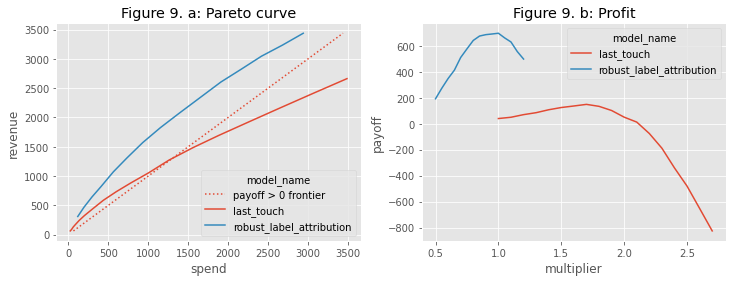

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4) )

axes[0].plot([metrics_df["revenue"].min(), metrics_df["revenue"].max()], [metrics_df["revenue"].min(), metrics_df["revenue"].max()], ls=":", label="payoff > 0 frontier")
sns.lineplot(data=metrics_df, x="spend", y="revenue", hue="model_name", ax=axes[0])
axes[0].set_title("Figure 9. a: Pareto curve")

sns.lineplot(data=metrics_df, x="multiplier", y="payoff", hue="model_name", ax=axes[1])
axes[1].set_title("Figure 9. b: Profit")
None